In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, mean_squared_error, r2_score
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler
from category_encoders.leave_one_out import LeaveOneOutEncoder
from functools import reduce

pd.set_option('future.no_silent_downcasting', True)
import warnings
warnings.filterwarnings('ignore')

Load data frame

In [51]:
# Creat names of columns
columns = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'target']

# Read csv file
df = pd.read_csv('./credit+approval/crx.data', names=columns, delimiter=',',  na_values='?')

#Get dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   c1      678 non-null    object 
 1   c2      678 non-null    float64
 2   c3      690 non-null    float64
 3   c4      684 non-null    object 
 4   c5      684 non-null    object 
 5   c6      681 non-null    object 
 6   c7      681 non-null    object 
 7   c8      690 non-null    float64
 8   c9      690 non-null    object 
 9   c10     690 non-null    object 
 10  c11     690 non-null    int64  
 11  c12     690 non-null    object 
 12  c13     690 non-null    object 
 13  c14     677 non-null    float64
 14  c15     690 non-null    int64  
 15  target  690 non-null    object 
dtypes: float64(4), int64(2), object(10)
memory usage: 86.4+ KB


We can see that almost all columns have object type and we need to convert them to number type

Prepare data

In [52]:
# Convert target "+" and "-" values to number 1 and 0 values
df['target'] = df['target'].map({"+": 1, "-": 0}).astype('int8')

# Collect columns which will encode to number values
encode_columns = ['c1', 'c4', 'c5', 'c6', 'c7', 'c9', 'c10', 'c12', 'c13']

# Creaate encoder
encoder = LeaveOneOutEncoder(cols=encode_columns)

# Transform data
df = encoder.fit_transform(df, df['target'])

# Get info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   c1      690 non-null    float64
 1   c2      678 non-null    float64
 2   c3      690 non-null    float64
 3   c4      690 non-null    float64
 4   c5      690 non-null    float64
 5   c6      690 non-null    float64
 6   c7      690 non-null    float64
 7   c8      690 non-null    float64
 8   c9      690 non-null    float64
 9   c10     690 non-null    float64
 10  c11     690 non-null    int64  
 11  c12     690 non-null    float64
 12  c13     690 non-null    float64
 13  c14     677 non-null    float64
 14  c15     690 non-null    int64  
 15  target  690 non-null    int8   
dtypes: float64(13), int64(2), int8(1)
memory usage: 81.7 KB


In [53]:
# Display first 10 rows
df.head(10)

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,target
0,0.438972,30.83,0.000,0.492278,0.492278,0.507937,0.422111,1.250,0.786111,0.707483,1,0.428954,0.458333,202.0,0,1
1,0.464115,58.67,4.460,0.492278,0.492278,0.649351,0.627737,3.040,0.786111,0.707483,6,0.428954,0.458333,43.0,560,1
2,0.464115,24.50,0.500,0.492278,0.492278,0.649351,0.627737,1.500,0.786111,0.246193,0,0.428954,0.458333,280.0,824,1
3,0.438972,27.83,1.540,0.492278,0.492278,0.507937,0.422111,3.750,0.786111,0.707483,5,0.460317,0.458333,100.0,3,1
4,0.438972,20.17,5.625,0.492278,0.492278,0.507937,0.422111,1.710,0.786111,0.246193,0,0.428954,0.250000,120.0,0,1
5,0.438972,32.08,4.000,0.492278,0.492278,0.405405,0.422111,2.500,0.786111,0.246193,0,0.460317,0.458333,360.0,0,1
6,0.438972,33.17,1.040,0.492278,0.492278,0.500000,0.627737,6.500,0.786111,0.246193,0,0.460317,0.458333,164.0,31285,1
7,0.464115,22.92,11.585,0.492278,0.492278,0.700000,0.422111,0.040,0.786111,0.246193,0,0.428954,0.458333,80.0,1349,1
8,0.438972,54.42,0.500,0.271605,0.271605,0.260000,0.627737,3.960,0.786111,0.246193,0,0.428954,0.458333,180.0,314,1
9,0.438972,42.50,4.915,0.271605,0.271605,0.507937,0.422111,3.165,0.786111,0.246193,0,0.460317,0.458333,52.0,1442,1


We converted all categorial features to number values

Correlation info

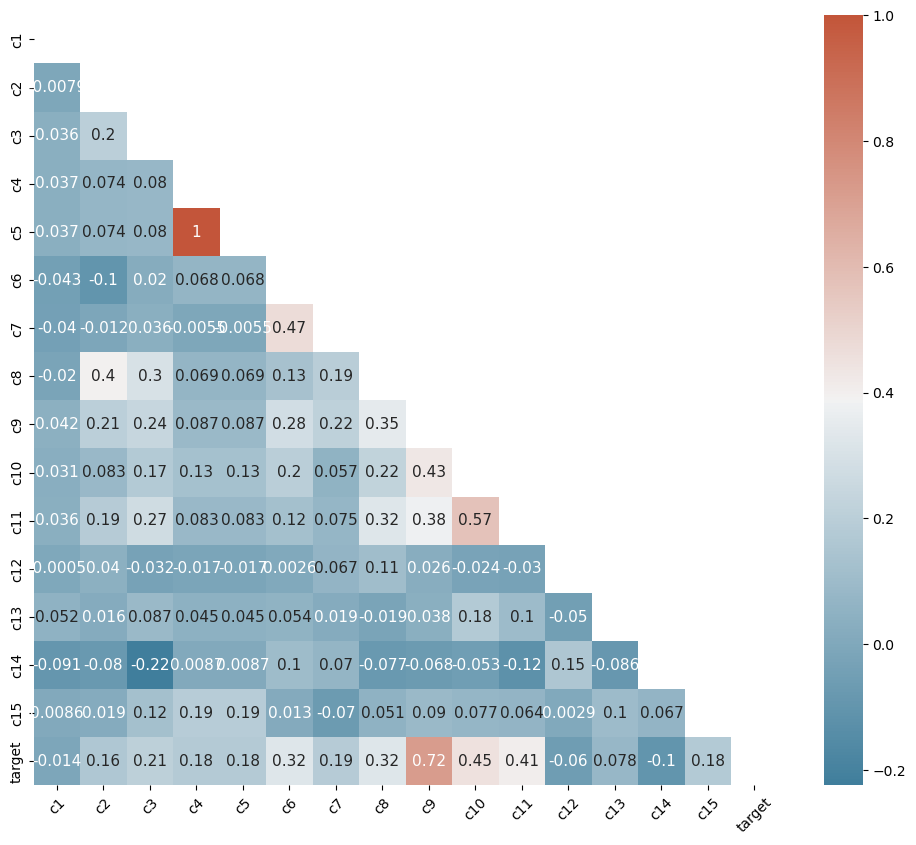

In [54]:
# Build correlation matrix
corr_matrix = df.corr()

# Set plot sixe 
plt.figure(figsize=(12, 10))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
# Visualize correlation matrix
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, annot=True, annot_kws={"fontsize":11})

# Show plot
plt.xticks(rotation=45)
plt.show()

We can observe that 'C4' and 'C5' features have max correlation. We need drop one of them

In [55]:
# Drop column 'c5'
df = df.drop('c5', axis=1)

# Create a new features
c0_values = reduce(lambda x, y: y ** 2 / (x + y), [df[col] for col in df.columns])
c5_values = reduce(lambda x, y: np.sqrt(y * x) , [df[col] for col in df.columns])

# Insert in order
df.insert(0, 'c0', c0_values)
df.insert(5, 'c5', c5_values)

# Get info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   c0      463 non-null    float64
 1   c1      690 non-null    float64
 2   c2      678 non-null    float64
 3   c3      690 non-null    float64
 4   c4      690 non-null    float64
 5   c5      666 non-null    float64
 6   c6      690 non-null    float64
 7   c7      690 non-null    float64
 8   c8      690 non-null    float64
 9   c9      690 non-null    float64
 10  c10     690 non-null    float64
 11  c11     690 non-null    int64  
 12  c12     690 non-null    float64
 13  c13     690 non-null    float64
 14  c14     677 non-null    float64
 15  c15     690 non-null    int64  
 16  target  690 non-null    int8   
dtypes: float64(14), int64(2), int8(1)
memory usage: 87.1 KB


Make correllation again to ensure that everything is ok

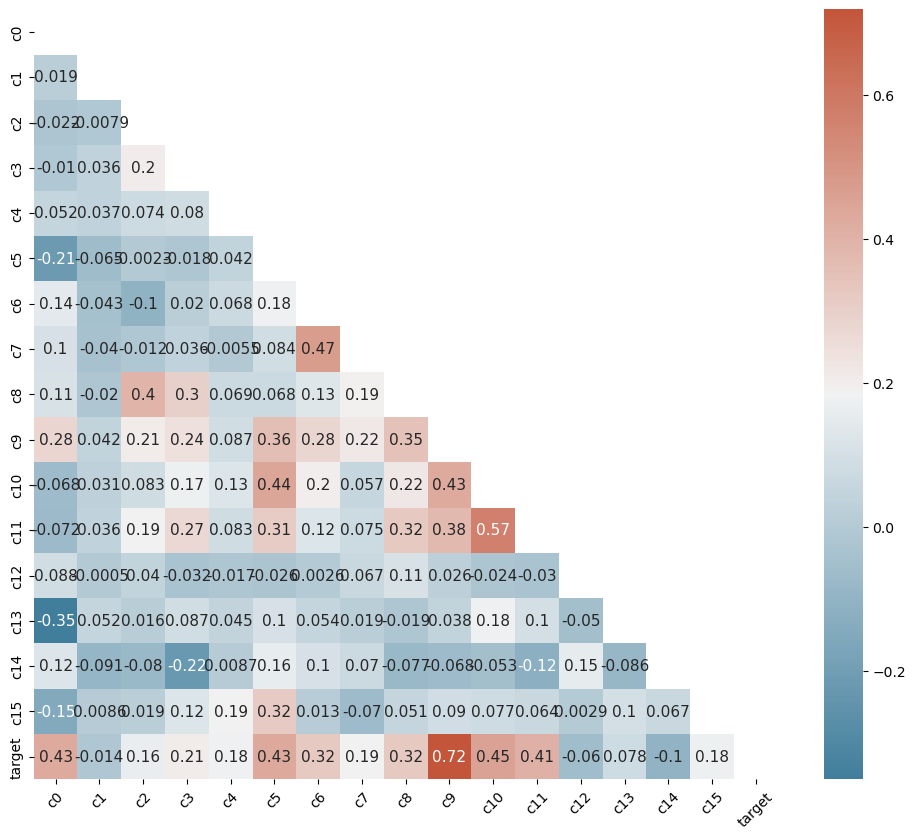

In [56]:
# Build correlation matrix
corr_matrix = df.corr()

# Set plot sixe 
plt.figure(figsize=(12, 10))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
# Visualize correlation matrix
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, annot=True, annot_kws={"fontsize":11})

# Show plot
plt.xticks(rotation=45)
plt.show()

Now correlation matrix has good values. But previous one seems better

Visualize, visualize, visualize ...

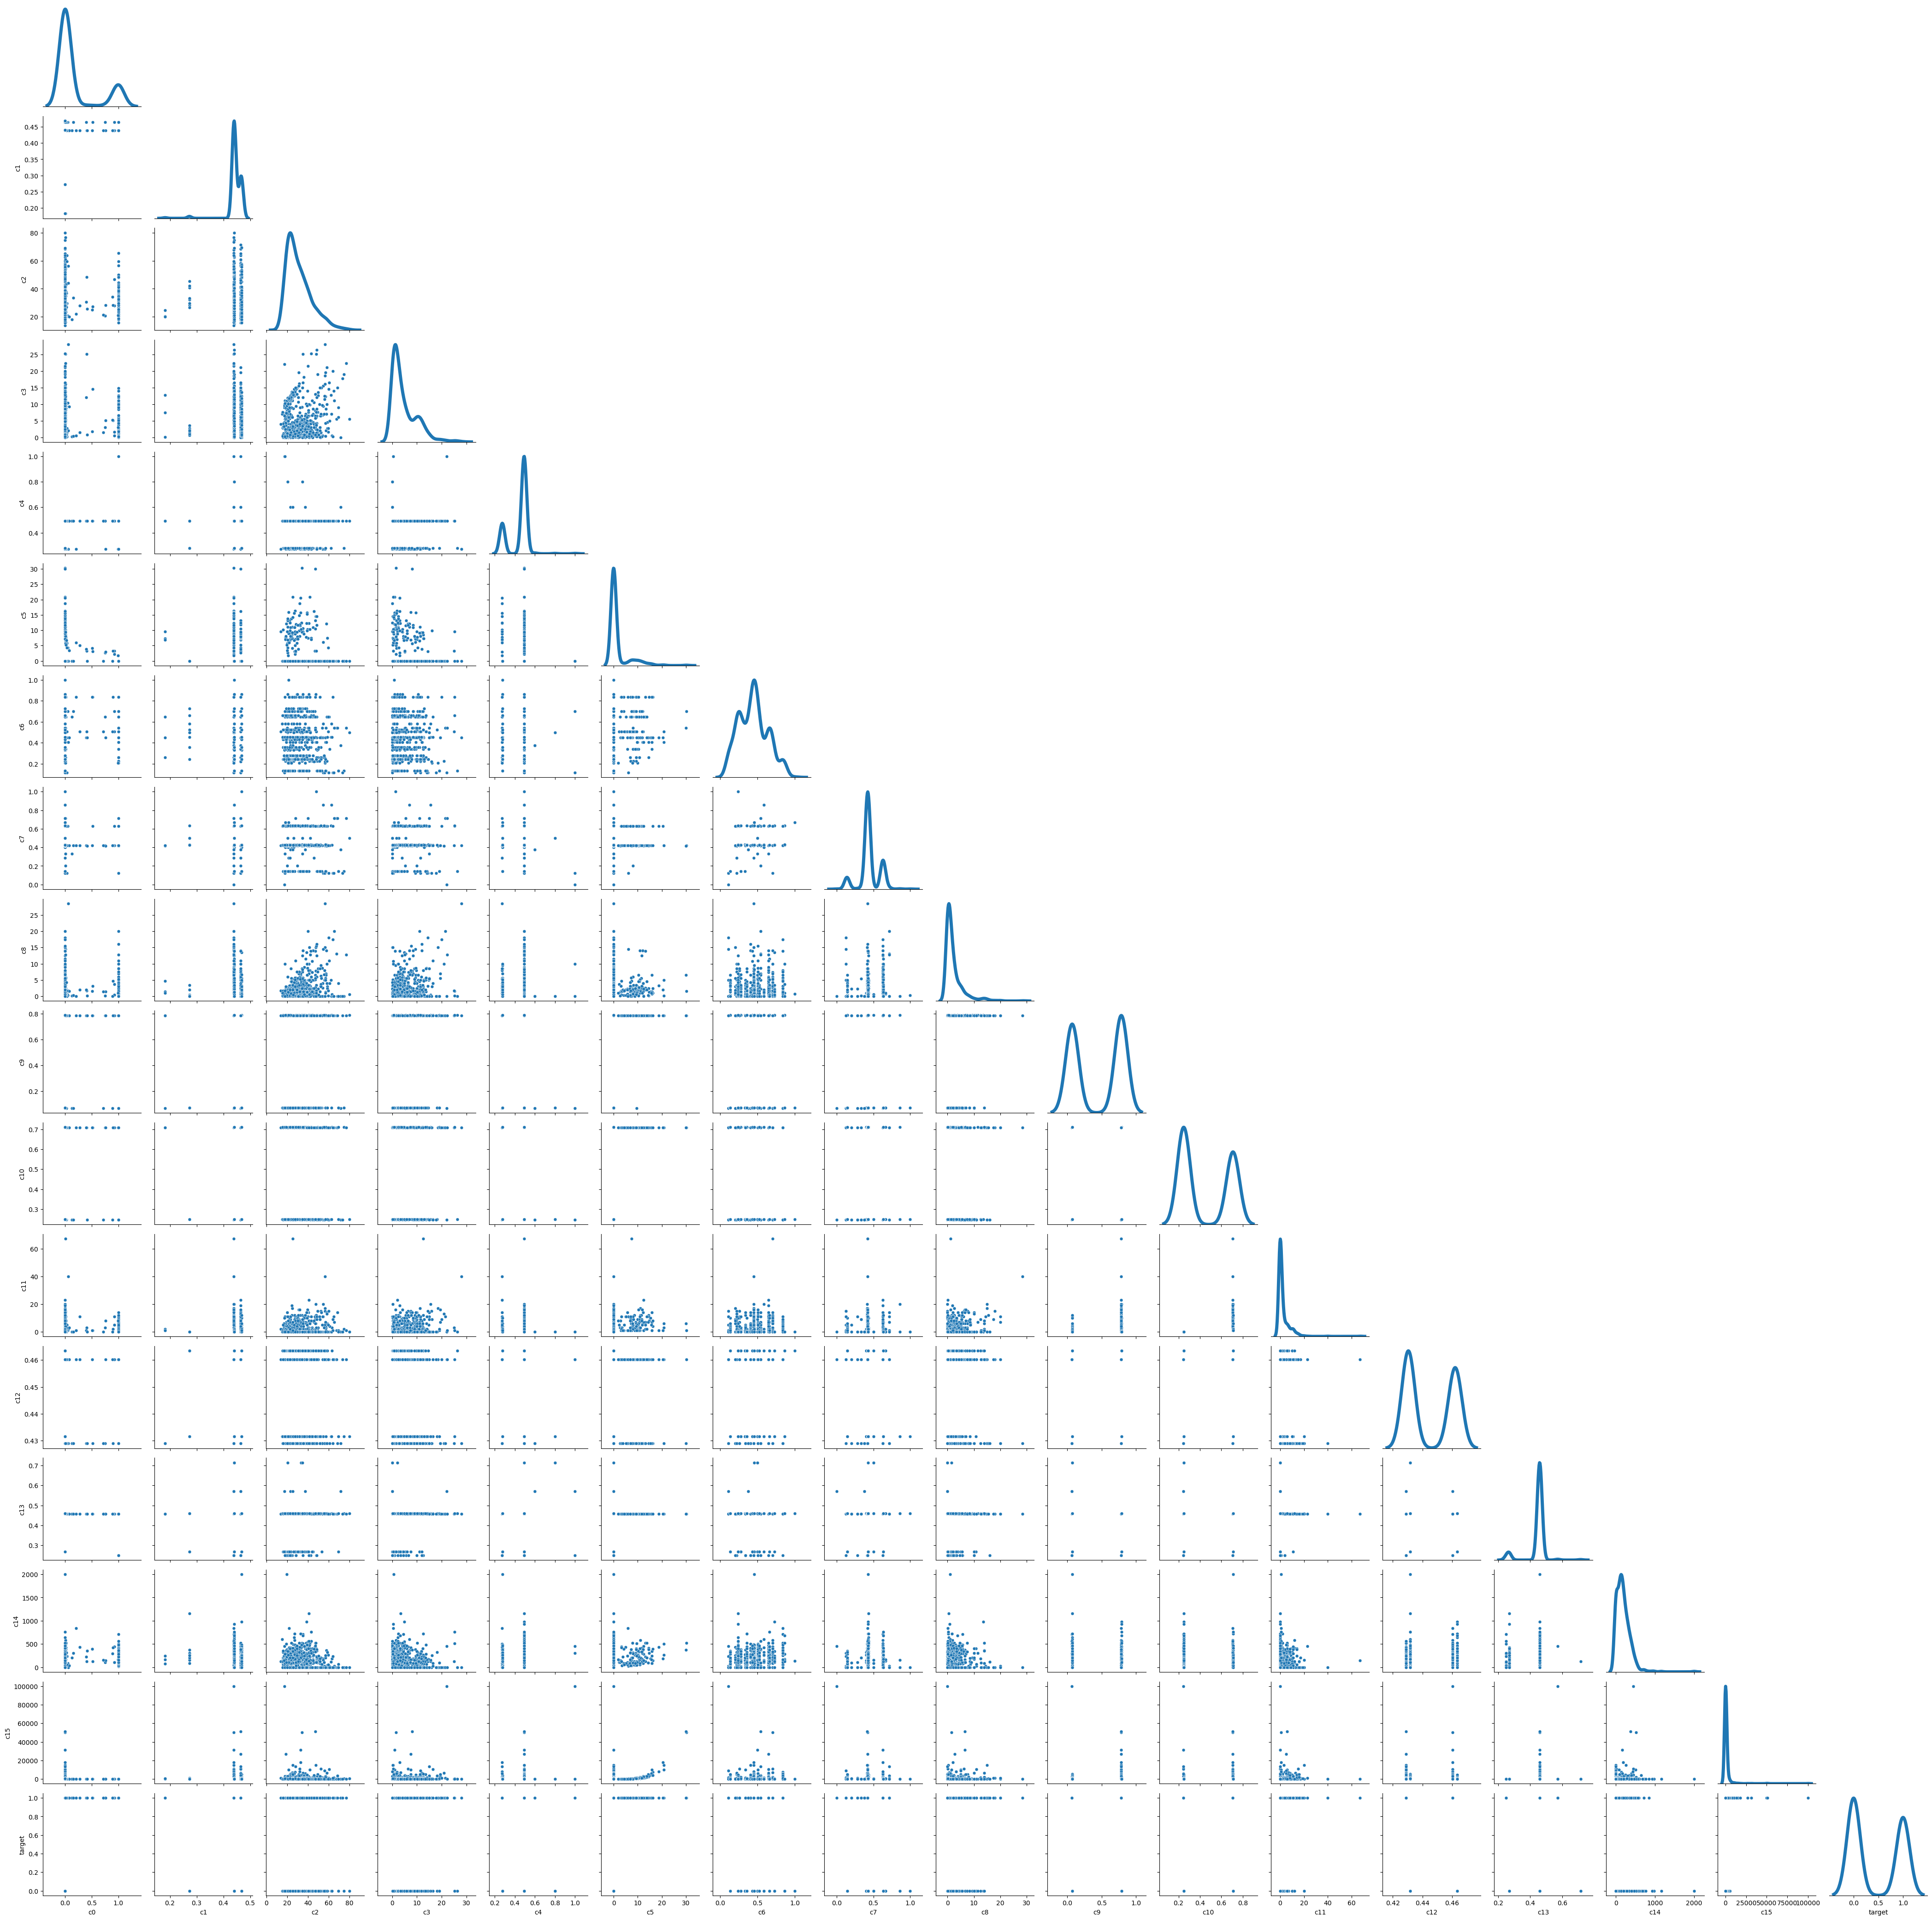

In [57]:
# Visualize pair grid for our model
pairGrid = sns.PairGrid(df, corner=True, diag_sharey=False)

# Lower part of grid
pairGrid.map_lower(sns.scatterplot, s=25)

# Diagonal 
pairGrid.map_diag(sns.kdeplot, lw=5)

In the Grid above we can observe some minimal dependencies of feature and outlayers, but in general it won't be affected to result.

In [58]:
# Split the data into features (X) and target variable (y)
X = df.drop("target", axis=1).fillna(0)
y = df["target"]

Scale and split the data

In [59]:
# Scale the data using StandardScaler
scaler = MinMaxScaler()

# Scale X 
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=True)

Apply scaler to data frame and split out data in proportion 0.8 for train and 0.2 for test. 

[Text(0.5, 0.9375, 'x[0] <= 0.0\ngini = 0.49\nsamples = 100.0%\nvalue = [0.571, 0.429]'),
 Text(0.4090909090909091, 0.8125, 'x[10] <= 0.003\ngini = 0.167\nsamples = 62.9%\nvalue = [0.908, 0.092]'),
 Text(0.4545454545454546, 0.875, 'True  '),
 Text(0.3181818181818182, 0.6875, 'gini = 0.0\nsamples = 3.3%\nvalue = [0.0, 1.0]'),
 Text(0.5, 0.6875, 'x[12] <= 0.039\ngini = 0.081\nsamples = 59.6%\nvalue = [0.957, 0.043]'),
 Text(0.4090909090909091, 0.5625, 'gini = 0.0\nsamples = 1.3%\nvalue = [0.0, 1.0]'),
 Text(0.5909090909090909, 0.5625, 'x[11] <= 0.097\ngini = 0.043\nsamples = 58.3%\nvalue = [0.978, 0.022]'),
 Text(0.36363636363636365, 0.4375, 'x[8] <= 0.447\ngini = 0.019\nsamples = 56.3%\nvalue = [0.99, 0.01]'),
 Text(0.18181818181818182, 0.3125, 'x[8] <= 0.184\ngini = 0.013\nsamples = 56.0%\nvalue = [0.994, 0.006]'),
 Text(0.09090909090909091, 0.1875, 'gini = 0.0\nsamples = 53.1%\nvalue = [1.0, 0.0]'),
 Text(0.2727272727272727, 0.1875, 'x[6] <= 0.533\ngini = 0.219\nsamples = 2.9%\nvalue 

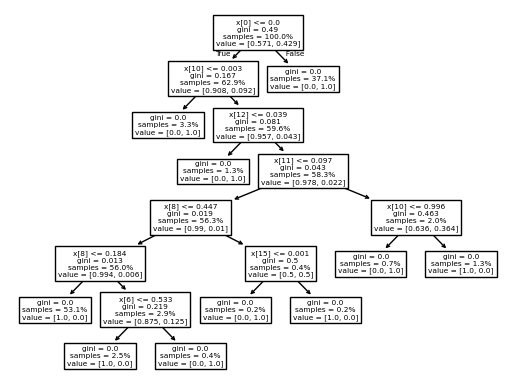

In [60]:
# Create Tree Classifier
tree_classifier = DecisionTreeClassifier(random_state=42)
# Fit data
tree_classifier.fit(X_train,y_train)

tree.plot_tree(tree_classifier, proportion=True)

In the plot, we can see that not all features are needed to build the tree. A depth of 7 is enough to build a full hierarchy. 

In [61]:
# Cross validation data
cv_sc = cross_val_score(tree_classifier, X_train, y_train, cv=4)
print(f"Cross-Validation Scores: {np.mean(cv_sc)}")

Cross-Validation Scores: 0.9891304347826086


We can observe that closs validatation has good balanced data

In [62]:
# Create hyperparameters 
parameters = {"max_depth": np.arange(1, 11), "max_features": [0.5, 0.7, 1]}
grid_search = GridSearchCV(estimator = tree_classifier,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 4,
                           verbose=0)


grid_search.fit(X_train, y_train)   
best_reg = grid_search.best_estimator_
y_pred = best_reg.predict(X_test)

print(classification_report(y_test, y_pred, target_names=[f'class_{i}' for i in range(2)]))

              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        68
     class_1       1.00      1.00      1.00        70

    accuracy                           1.00       138
   macro avg       1.00      1.00      1.00       138
weighted avg       1.00      1.00      1.00       138



Very well metrics. 

In [63]:
# Get score and best params
grid_search.best_score_, grid_search.best_params_

(np.float64(0.9963768115942029),
 {'max_depth': np.int64(7), 'max_features': 0.5})

In [64]:
# Predict result
y_pred_imp = tree_classifier.predict(X_test)

# Calculate MSE error and R2 score
mse = mean_squared_error(y_test, y_pred_imp)
r2 = r2_score(y_test, y_pred_imp)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

Mean Squared Error (MSE): 0.028985507246376812
R-squared (R²): 0.8840336134453781


MSE equal 0.02 and R2 0.88 tell us that the model was trained excellent with 100% prediction.

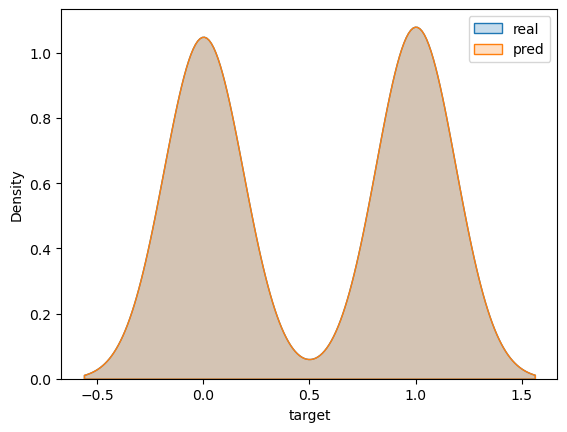

In [65]:
# Visualize our result
sns.kdeplot(y_test, fill=True, label='real')
sns.kdeplot(np.around(y_pred, 0), fill=True, label='pred')
plt.legend()

The plot claims that our model is ideal. Very good result.

Let try the NeighborsClassifier

Let try to calclulate best parameters for neighbors classifier

In [66]:
# # Create  Neigghbors Classifier
knn_cl = KNeighborsClassifier(n_neighbors=5)

# # Create Grid Search to calculate the best count neighbors for kNN model
param_grid = {'n_neighbors': range(1, 20)}
grid_search = GridSearchCV(knn_cl, param_grid, cv=4, scoring='r2')
grid_search.fit(X_train, y_train)

print(f"Best k: {grid_search.best_params_['n_neighbors']}")
print(f"Best R-squared (R²): {grid_search.best_score_}")

Best k: 7
Best R-squared (R²): 0.6007511181159539


Grid search tell us that with 7 neighbors the result will be better. 

In [67]:
# Cross validataion neighbors classifier model
cv_sc = cross_val_score(knn_cl, X_train, y_train, cv=7)
print(f"Cross-Validation Scores: {np.mean(cv_sc)}")

Cross-Validation Scores: 0.8785644735011823


Not bad, but we want to better

Let's try with 7 neighbors 

In [68]:
# # Create  Neigghbors Classifier
knn_class = KNeighborsClassifier(n_neighbors=7)

# Cross validataion neighbors classifier model
cv_sc = cross_val_score(knn_cl, X_train, y_train, cv=7)
print(f"Cross-Validation Scores: {np.mean(cv_sc)}")

Cross-Validation Scores: 0.8785644735011823


The result of cross validatation leaves the same as with 5 neigbors

Evaluate model 

In [69]:
# Make a prediction
knn_class.fit(X_train, y_train)
y_pred = knn_class.predict(X_test)

# Evaluate the model's performance
best_reg = grid_search.best_estimator_
y_pred = best_reg.predict(X_test)

print(classification_report(y_test, y_pred, target_names=[f'class_{i}' for i in range(2)]))

              precision    recall  f1-score   support

     class_0       0.90      0.97      0.94        68
     class_1       0.97      0.90      0.93        70

    accuracy                           0.93       138
   macro avg       0.94      0.94      0.93       138
weighted avg       0.94      0.93      0.93       138



Not bad, but Tree classifier model had metrics better than Neighbors classifier model

Visualize result 

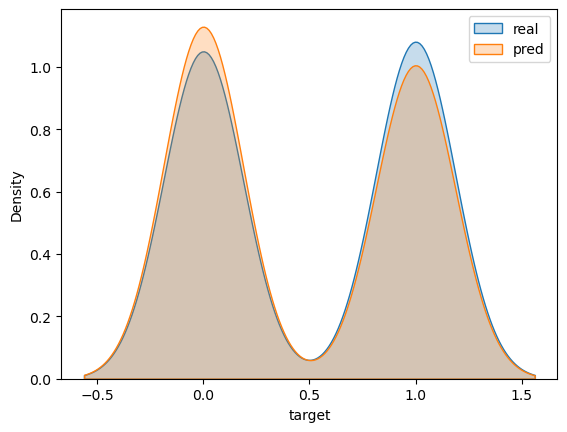

In [70]:
# Visualize our result
sns.kdeplot(y_test, fill=True, label='real')
sns.kdeplot(np.around(y_pred, 0), fill=True, label='pred')
plt.legend()

The same result we can observe on the plot above

Let's try Logistic Regression

In [71]:
# Create Logistic Regression model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train,y_train)

# Cross validataion neighbors classifier model
cv_sc = cross_val_score(log_reg, X_train, y_train, cv=4)
print(f"Cross-Validation Scores: {np.mean(cv_sc)}")

Cross-Validation Scores: 0.9039855072463768


Cross validation is a little bit better than Neighbors model 

Evaluate model

In [72]:
# Create hyperparameters
parameters = [{'penalty':['l2']}, 
              {'C':[1, 10, 100, 1000]}]
grid_search = GridSearchCV(estimator = log_reg,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 4,
                           verbose=0)

# Fit data 
grid_search.fit(X_train, y_train)   
best_reg = grid_search.best_estimator_

# Make a prediction
y_pred = best_reg.predict(X_test)

print(classification_report(y_test, y_pred, target_names=[f'class_{i}' for i in range(2)]))

              precision    recall  f1-score   support

     class_0       0.89      0.94      0.91        68
     class_1       0.94      0.89      0.91        70

    accuracy                           0.91       138
   macro avg       0.91      0.91      0.91       138
weighted avg       0.91      0.91      0.91       138



But metrics are worse than Neighbors Regression model

Visualize

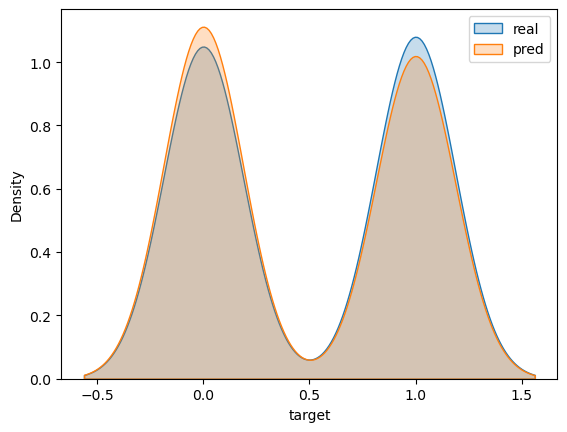

In [73]:
# Visualize our result
sns.kdeplot(y_test, fill=True, label='real')
sns.kdeplot(np.around(y_pred, 0), fill=True, label='pred')
plt.legend()

The same picture as Neighbors Regression model. Identical result

Conclusion: The best from all regression models is Decision Tree Classsifier model. It shows excellent parameters and can predict value with 100 result. Other models have good result as well but a little bit less than first one. Suppose good balance dataframe and filled data helped us achive so quite well result.